In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import matplotlib as mpl
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import shap
import optuna
import math

import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [7]:
file_path = "/kaggle/input/dataset-scm/Results_AI.xlsx"
data = pd.read_excel(file_path)

# EDA

In [8]:
data.head()

,Cement,Metakaolin,Fly ash,Silica Fume,Rice Husk Ash,Curing age,Compressive Strength,Water Permeability
0,403.2,0.0,0.0,0.0,0.0,7,11.02,0.74
1,403.2,0.0,0.0,0.0,0.0,7,11.12,0.71
2,403.2,0.0,0.0,0.0,0.0,7,11.29,0.69
3,383.0,20.2,0.0,0.0,0.0,7,11.11,0.60
4,383.0,20.2,0.0,0.0,0.0,7,11.38,0.73


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cement                240 non-null    float64
 1   Metakaolin            240 non-null    float64
 2   Fly ash               240 non-null    float64
 3   Silica Fume           240 non-null    float64
 4   Rice Husk Ash         240 non-null    float64
 5   Curing age            240 non-null    int64  
 6   Compressive Strength  240 non-null    float64
 7   Water Permeability    240 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 15.1 KB


In [10]:
data.describe()

,Cement,Metakaolin,Fly ash,Silica Fume,Rice Husk Ash,Curing age,Compressive Strength,Water Permeability
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,362.840000,10.075000,10.075000,10.075000,10.075000,122.500000,13.415458,0.353333
std,28.570185,22.575483,22.575483,22.575483,22.575483,143.593744,2.944585,0.183494
min,322.600000,0.000000,0.000000,0.000000,0.000000,7.000000,6.270000,0.010000
25%,342.600000,0.000000,0.000000,0.000000,0.000000,22.750000,11.290000,0.250000
50%,362.800000,0.000000,0.000000,0.000000,0.000000,59.000000,13.000000,0.320000
75%,383.000000,0.000000,0.000000,0.000000,0.000000,158.750000,15.212500,0.460000
max,403.200000,80.600000,80.600000,80.600000,80.600000,365.000000,26.430000,0.770000


In [11]:
stats_table = pd.DataFrame({
    "Max": data.max(),
    "Min": data.min(),
    "Mean": data.mean(),
    "Std Dev": data.std(),
    "Skewness": data.apply(skew),
    "Kurtosis": data.apply(kurtosis)
})

pd.options.display.float_format = '{:.4f}'.format  
print(stats_table)

                          Max      Min     Mean  Std Dev  Skewness  Kurtosis
Cement               403.2000 322.6000 362.8400  28.5702    0.0042   -1.3024
Metakaolin            80.6000   0.0000  10.0750  22.5755    2.1472    3.2509
Fly ash               80.6000   0.0000  10.0750  22.5755    2.1472    3.2509
Silica Fume           80.6000   0.0000  10.0750  22.5755    2.1472    3.2509
Rice Husk Ash         80.6000   0.0000  10.0750  22.5755    2.1472    3.2509
Curing age           365.0000   7.0000 122.5000 143.5937    1.0061   -0.7960
Compressive Strength  26.4300   6.2700  13.4155   2.9446    0.5821    1.3647
Water Permeability     0.7700   0.0100   0.3533   0.1835    0.4268   -0.2665


* Cement has symmetric distribution as the mean value is the average of min and max value.
* Metakaolin, Fly Ash, Silica Fume, Rice Husk Ash are positively skewed means most values are low as these materials are not always used.
* Most samples are cured for less than 122 days and a few long cures exist.
* CS has most of the values cluster around the mean and slight asymmetry and a few higher strength values

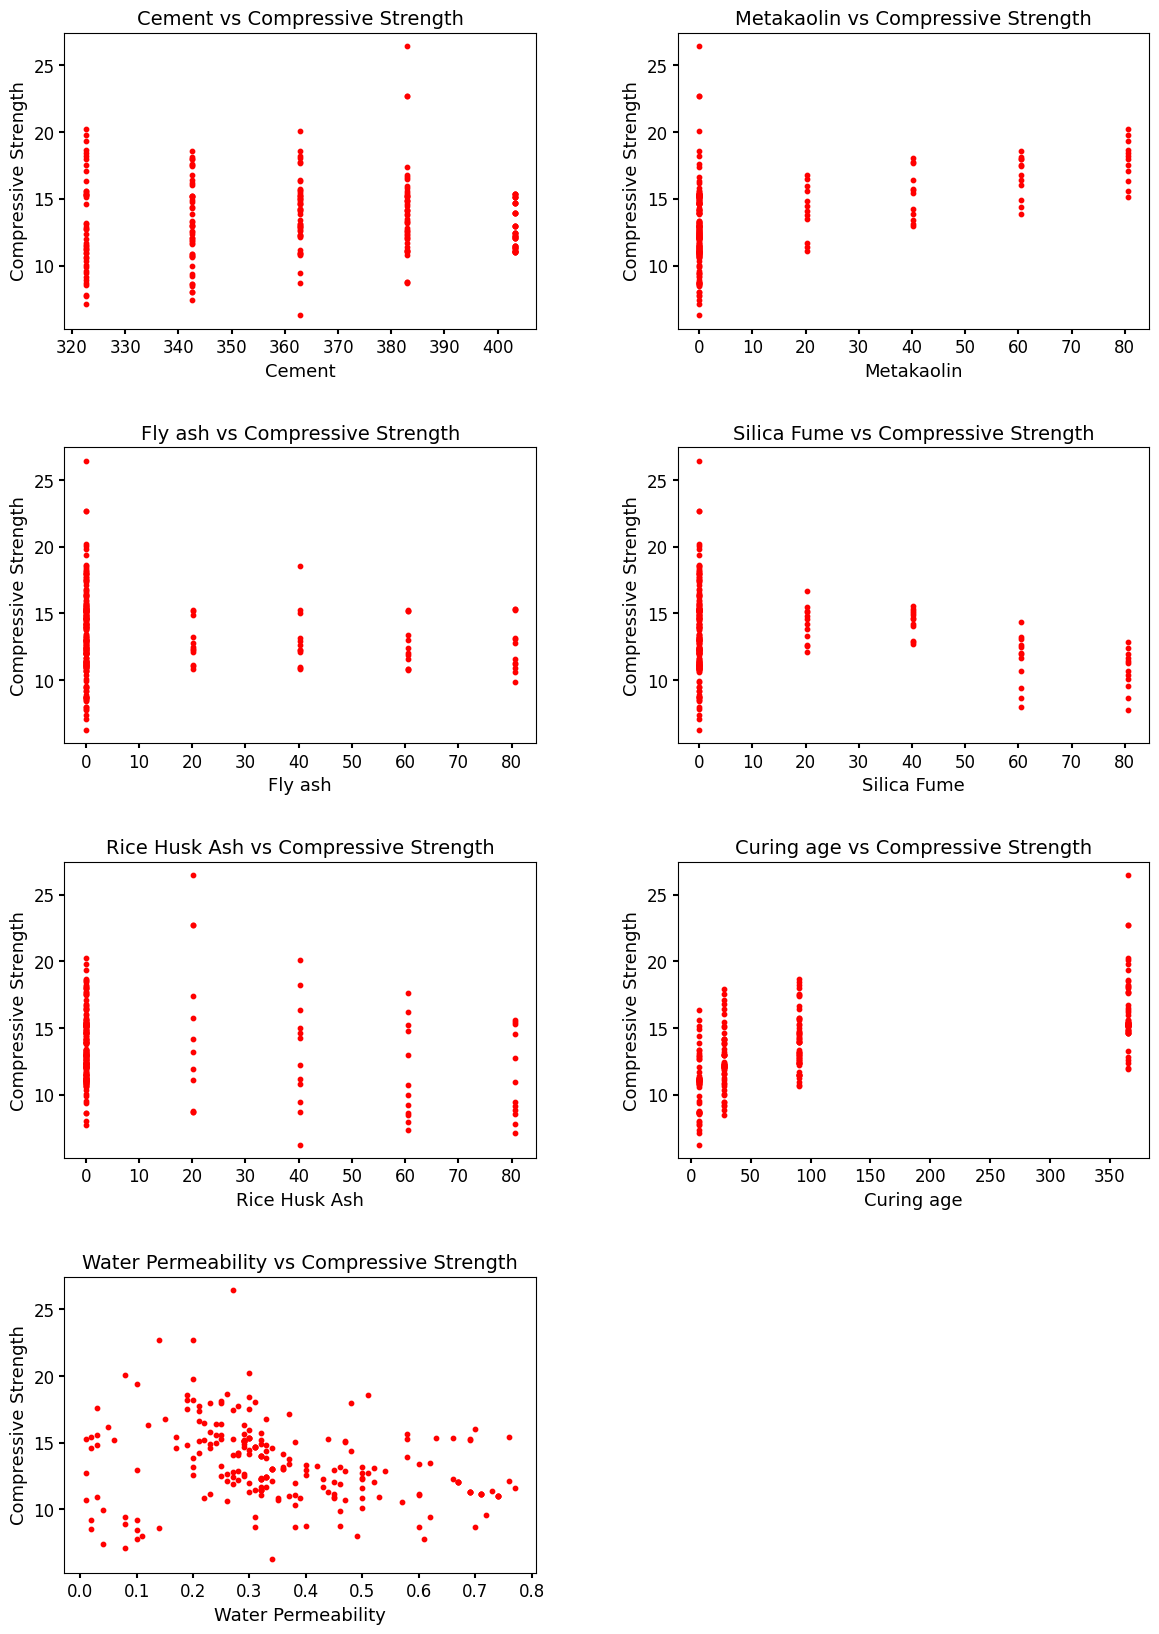

In [14]:
target = 'Compressive Strength'
features = [col for col in data.columns if col != target]

n_rows = math.ceil(len(features) / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(14, 5 * n_rows))
axs = axs.ravel()

for i, feature in enumerate(features):
    axs[i].scatter(data[feature], data[target], color='red', s=10)
    axs[i].set_xlabel(feature, fontsize=13)
    axs[i].set_ylabel(target, fontsize=13)
    axs[i].set_title(f'{feature} vs {target}', fontsize=14)
    axs[i].tick_params(axis='both', labelsize=12, width=1.5, labelcolor='black')

if len(features) < len(axs):
    for j in range(len(features), len(axs)):
        fig.delaxes(axs[j])

plt.subplots_adjust(hspace=0.4, wspace=0.3) 
plt.show()


* As the cement quantity increases, compressive strength tends to increase, indicating a positive correlation.
* As Metakaolin increases, Compressive Strength appears to increase, but the relationship is weaker than for cement.
* For FA, SF and RHA No monotonic trend is visible. On average it seems to slightly decline.
* As curing age increases from 0 to 365 days, Compressive Strength consistently increases.
* As Water Permeability increases, Compressive Strength generally decreases.
There’s a cluster of high compressive strength values at low permeability (≤0.2), and much lower strength when permeability increases beyond 0.5.

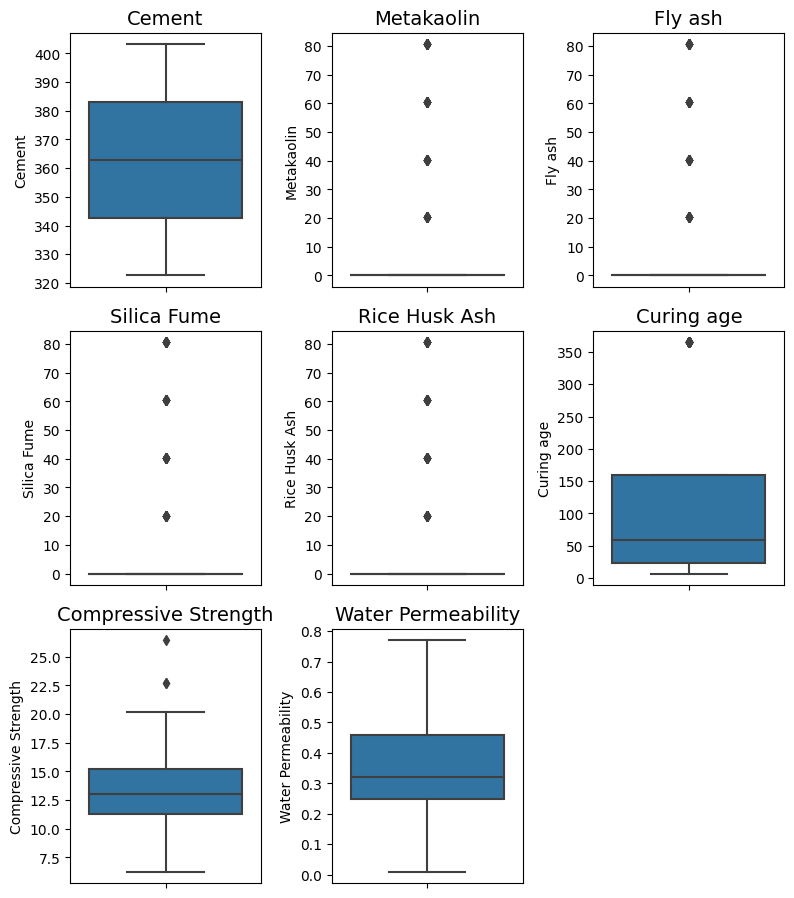

In [15]:
cols = data.columns
plt.figure(figsize=(8, 15))
plotnumber = 1

for i in range(len(cols)):
    ax = plt.subplot(5, 3, plotnumber)
    sns.boxplot(y=data[cols[i]], ax=ax)
    ax.set_title(f"{cols[i]}", fontsize=14)
    plotnumber += 1

plt.tight_layout()
plt.show()

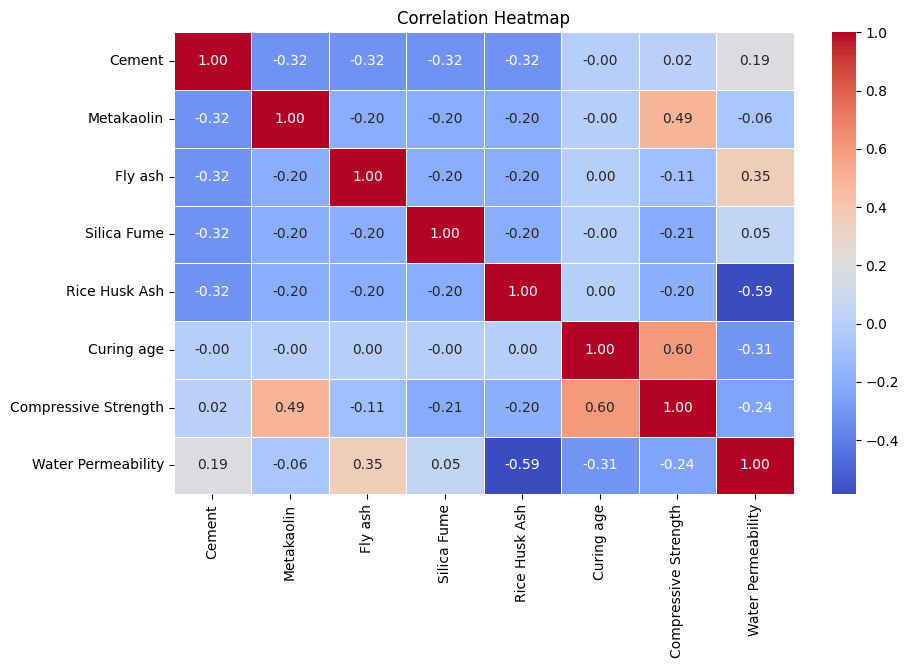

In [16]:
corr_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

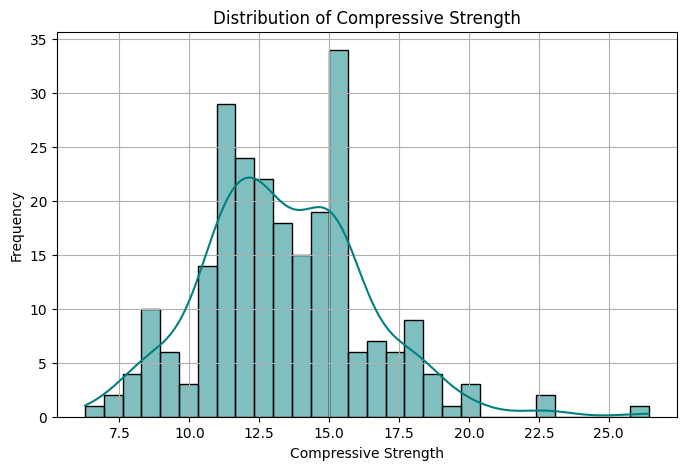

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(data['Compressive Strength'], kde=True, bins=30, color='teal')
plt.title('Distribution of Compressive Strength')
plt.xlabel('Compressive Strength')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

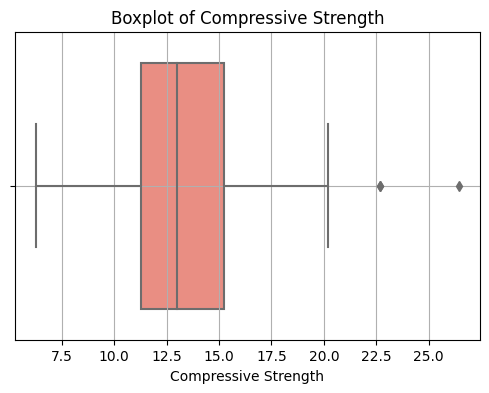

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(x=data['Compressive Strength'], color='salmon')
plt.title('Boxplot of Compressive Strength')
plt.xlabel('Compressive Strength')
plt.grid(True)
plt.show()

# Compressive Strength

<Axes: xlabel='Compressive Strength', ylabel='Count'>

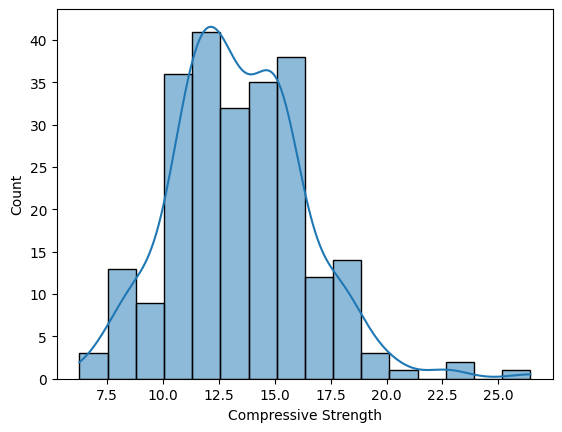

In [19]:
sns.histplot(data['Compressive Strength'], kde=True)

In [20]:
X = data[['Cement','Metakaolin','Fly ash','Silica Fume','Rice Husk Ash','Curing age']]
y = data[['Compressive Strength']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
# Initialize an empty DataFrame to store the results
columns = ['Model', 'Train R²', 'Train MAE', 'Train RMSE', 'Train MSE', 'Train MAPE', 
           'Test R²', 'Test MAE', 'Test RMSE', 'Test MSE', 'Test MAPE', 'CV R² Mean']
results_df = pd.DataFrame(columns=columns)

## Linear Models

In [22]:
def stepwise_selection(X, y, cv=5):
    remaining_features = list(X.columns)
    selected_features = []
    best_score = -np.inf

    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            model = LinearRegression()
            selected = selected_features + [candidate]
            score = cross_val_score(model, X[selected], y, cv=cv, scoring='r2').mean()
            scores_with_candidates.append((score, candidate))

        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]

        if best_new_score > best_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            best_score = best_new_score
        else:
            break

    return selected_features

def evaluate_model(name, model, X_train, y_train, X_test, y_test, results_df):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100

    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100

    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

    results_df = pd.concat([results_df, pd.DataFrame([{
        'Model': name,
        'Train R²': r2_train,
        'Train MAE': mae_train,
        'Train RMSE': rmse_train,
        'Train MSE': mse_train,
        'Train MAPE': mape_train,
        'Test R²': r2_test,
        'Test MAE': mae_test,
        'Test RMSE': rmse_test,
        'Test MSE': mse_test,
        'Test MAPE': mape_test,
        'CV R² Mean': cv_scores.mean()
    }])], ignore_index=True)

    return y_train_pred, y_test_pred, results_df

selected_features = stepwise_selection(X_train, y_train)

stepwise_model = LinearRegression()
stepwise_model.fit(X_train[selected_features], y_train)
train_pred, test_pred, results_df = evaluate_model("SLR", stepwise_model, X_train[selected_features], y_train, X_test[selected_features], y_test, results_df)

print("Selected Features:", selected_features)
print(results_df)

Selected Features: ['Metakaolin', 'Curing age', 'Cement']
  Model  Train R²  Train MAE  Train RMSE  Train MSE  Train MAPE  Test R²  Test MAE  Test RMSE  Test MSE  Test MAPE  CV R² Mean
0   SLR    0.6503     1.2370      1.7109     2.9272      9.9114   0.5824    1.3722     1.9839    3.9358    10.4991      0.6535


In [23]:
def plot_model_performance(y_train, y_train_pred, y_test, y_test_pred, model_name):

    y_actual_all = pd.concat([y_train, y_test]).reset_index(drop=True)
    y_pred_all = pd.concat([y_train_pred, y_test_pred]).reset_index(drop=True)
    error = y_actual_all.values.flatten() - y_pred_all.values.flatten()

    split_index = len(y_train)

    plt.figure(figsize=(16, 7))
    plt.plot(y_actual_all, color='red', linestyle='-', marker='*', label='Actual value')
    plt.scatter(range(len(y_pred_all)), y_pred_all, color='blue', s=40, label='Predicted value')
    plt.plot(range(len(y_pred_all)), error, 'k--', label='Error')

    plt.axvline(x=split_index, color='green', linestyle='--')
    plt.text(split_index / 2, y_actual_all.max() + 2, 'Training set',
             fontsize=12, fontweight='bold', color='black',
             bbox=dict(facecolor='white', edgecolor='red'))

    plt.text(split_index + 10, y_actual_all.max() + 2, 'Test set',
             fontsize=12, fontweight='bold', color='black',
             bbox=dict(facecolor='white', edgecolor='red'))

    plt.ylabel('Compressive Strength (MPa)', fontsize=14, fontweight='bold', color='red')
    plt.xlabel('Sample Index', fontsize=14, fontweight='bold', color='black')

    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.show()

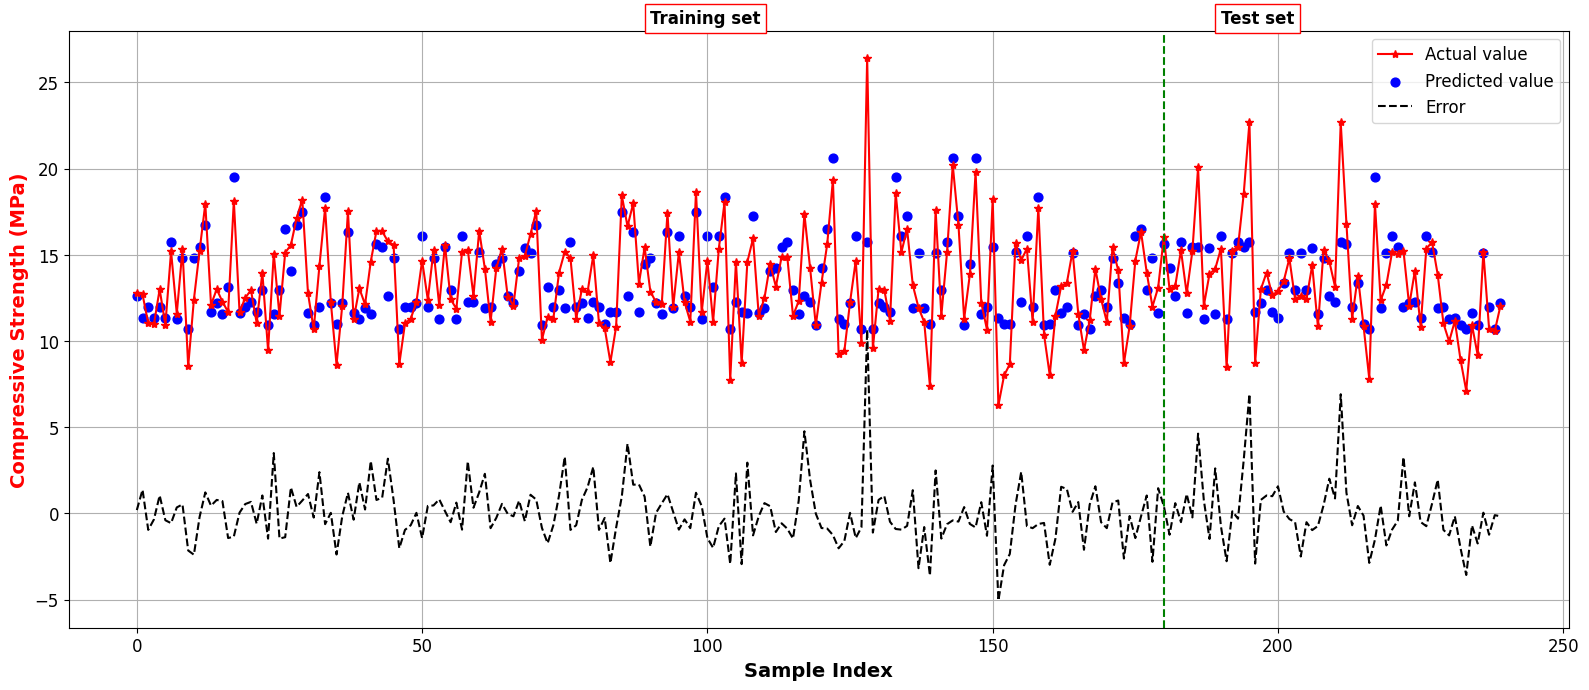

In [24]:
train_pred_series = pd.Series(train_pred.flatten())
test_pred_series = pd.Series(test_pred.flatten())

plot_model_performance(y_train.reset_index(drop=True), train_pred_series, y_test.reset_index(drop=True), test_pred_series, "SLR")

In [39]:
def plot_actual_vs_predicted(y_train, train_pred, y_test, test_pred, model_name="Model"):
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))  
    
    axs[0].scatter(y_train, train_pred, color='blue', label='Predicted')
    axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k-', label='Ideal')
    axs[0].plot([y_train.min(), y_train.max()],
                [y_train.min()*1.25, y_train.max()*1.25], 'r--', label='+25% Error')
    axs[0].plot([y_train.min(), y_train.max()],
                [y_train.min()*0.75, y_train.max()*0.75], 'r--', label='-25% Error')
    
    axs[0].set_xlabel('Actual value (MPa)', fontsize=16, fontweight='bold', color='blue')
    axs[0].set_ylabel('Predicted value (MPa)', fontsize=16, fontweight='bold', color='red')
    axs[0].set_title(f'Training Data - {model_name}', fontsize=19, pad=10)
    axs[0].legend(fontsize=14)
    axs[0].tick_params(axis='both', labelsize=14)
    axs[0].grid(True)

    axs[1].scatter(y_test, test_pred, color='blue', label='Predicted')
    axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', label='Ideal')
    axs[1].plot([y_test.min(), y_test.max()],
                [y_test.min()*1.25, y_test.max()*1.25], 'r--', label='+25% Error')
    axs[1].plot([y_test.min(), y_test.max()],
                [y_test.min()*0.75, y_test.max()*0.75], 'r--', label='-25% Error')
    
    axs[1].set_xlabel('Actual value (MPa)', fontsize=16, fontweight='bold', color='blue')
    axs[1].set_ylabel('Predicted value (MPa)', fontsize=16, fontweight='bold', color='red')
    axs[1].set_title(f'Test Data - {model_name}', fontsize=19, pad=10)
    axs[1].legend(fontsize=14)
    axs[1].tick_params(axis='both', labelsize=14)
    axs[1].grid(True)

    plt.subplots_adjust(wspace=0.3)  
    plt.tight_layout()
    plt.show()

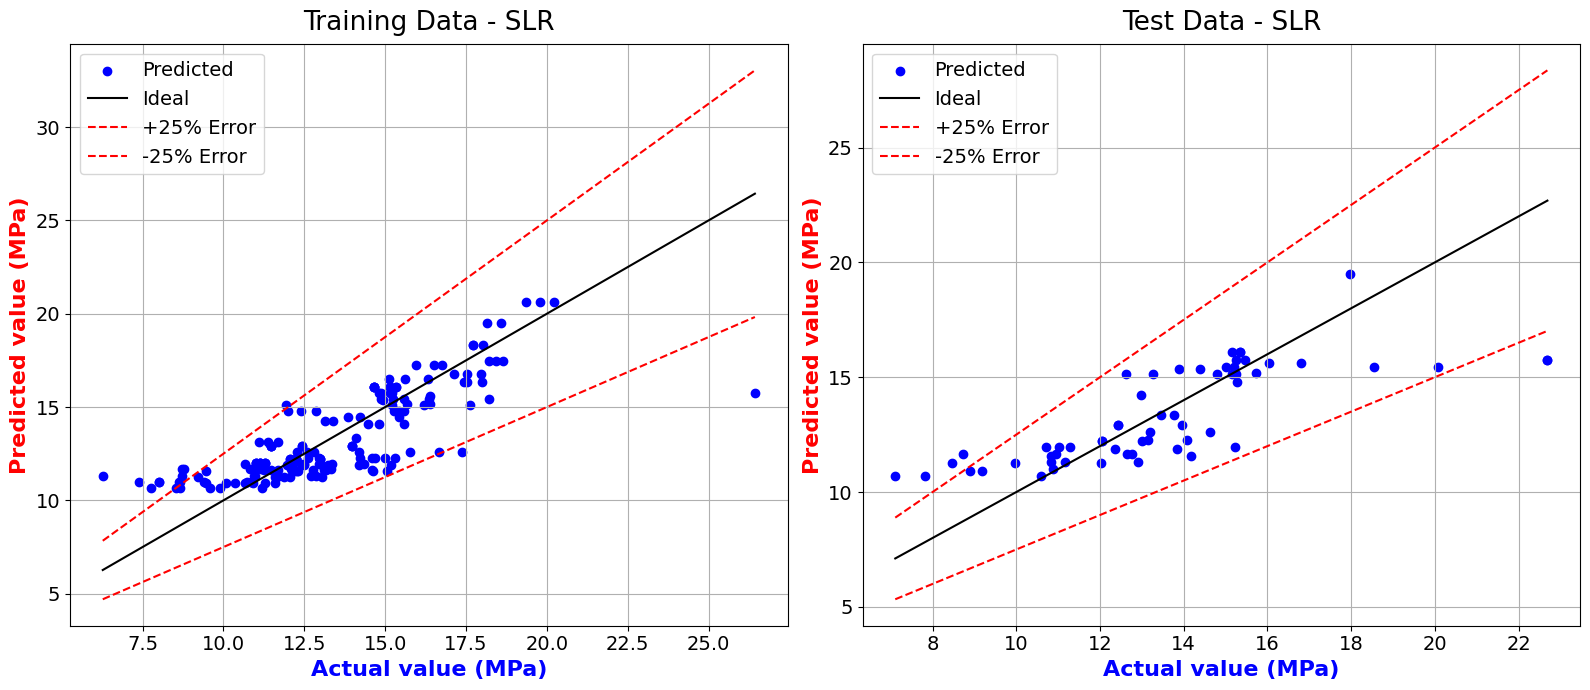

In [40]:
plot_actual_vs_predicted(y_train, train_pred, y_test, test_pred, model_name="SLR")

## Random Forest

In [41]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [20, 25, 30, 35, 40],
    'max_depth': [None, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [2, 4, 6, 8],
    'bootstrap': [True, False]
}

In [42]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 35}


In [43]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2")
print(f"Random Forest Cross-Validation R² Scores: {cv_scores}")
print(f"Average Random Forest R² Score: {cv_scores.mean():.4f}")

best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

y_train_pred_df = pd.DataFrame(y_train_pred, columns=['Predicted'])
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['Predicted'])

mse_train_rf = mean_squared_error(y_train, y_train_pred)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred)
r2_train_rf = r2_score(y_train, y_train_pred)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred)

mse_test_rf = mean_squared_error(y_test, y_test_pred)
rmse_test_rf = np.sqrt(mse_test_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred)
r2_test_rf = r2_score(y_test, y_test_pred)
mape_test_rf = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"\nRandom Forest Train Set Evaluation Metrics:")
print(f"R² Score: {r2_train_rf:.4f}")
print(f"MSE (Mean Squared Error): {mse_train_rf:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_train_rf:.4f}")
print(f"MAE (Mean Absolute Error): {mae_train_rf:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_train_rf:.4f}")

print(f"\nRandom Forest Test Set Evaluation Metrics:")
print(f"R² Score: {r2_test_rf:.4f}")
print(f"MSE (Mean Squared Error): {mse_test_rf:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_test_rf:.4f}")
print(f"MAE (Mean Absolute Error): {mae_test_rf:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_test_rf:.4f}")

Random Forest Cross-Validation R² Scores: [0.90979711 0.80223497 0.86864467 0.73507546 0.83832806]
Average Random Forest R² Score: 0.8308

Random Forest Train Set Evaluation Metrics:
R² Score: 0.9069
MSE (Mean Squared Error): 0.7789
RMSE (Root Mean Squared Error): 0.8826
MAE (Mean Absolute Error): 0.5163
MAPE (Mean Absolute Percentage Error): 0.0393

Random Forest Test Set Evaluation Metrics:
R² Score: 0.8293
MSE (Mean Squared Error): 1.6084
RMSE (Root Mean Squared Error): 1.2682
MAE (Mean Absolute Error): 0.7997
MAPE (Mean Absolute Percentage Error): 0.0591


In [44]:
rf_results = {
    'Model': 'Random Forest',
    'Train R²': r2_train_rf,
    'Train MAE': mae_train_rf,
    'Train RMSE': rmse_train_rf,
    'Train MSE': mse_train_rf,
    'Train MAPE': mape_train_rf * 100,
    'Test R²': r2_test_rf,
    'Test MAE': mae_test_rf,
    'Test RMSE': rmse_test_rf,
    'Test MSE': mse_test_rf,
    'Test MAPE': mape_test_rf * 100,
    'CV R² Mean': cv_scores.mean()
    
}

rf_results_df = pd.DataFrame([rf_results])
results_df = pd.concat([results_df, rf_results_df], ignore_index=True)

In [45]:
print(results_df)

           Model  Train R²  Train MAE  Train RMSE  Train MSE  Train MAPE  Test R²  Test MAE  Test RMSE  Test MSE  Test MAPE  CV R² Mean
0            SLR    0.6503     1.2370      1.7109     2.9272      9.9114   0.5824    1.3722     1.9839    3.9358    10.4991      0.6535
1  Random Forest    0.9069     0.5163      0.8826     0.7789      3.9314   0.8293    0.7997     1.2682    1.6084     5.9061      0.8308


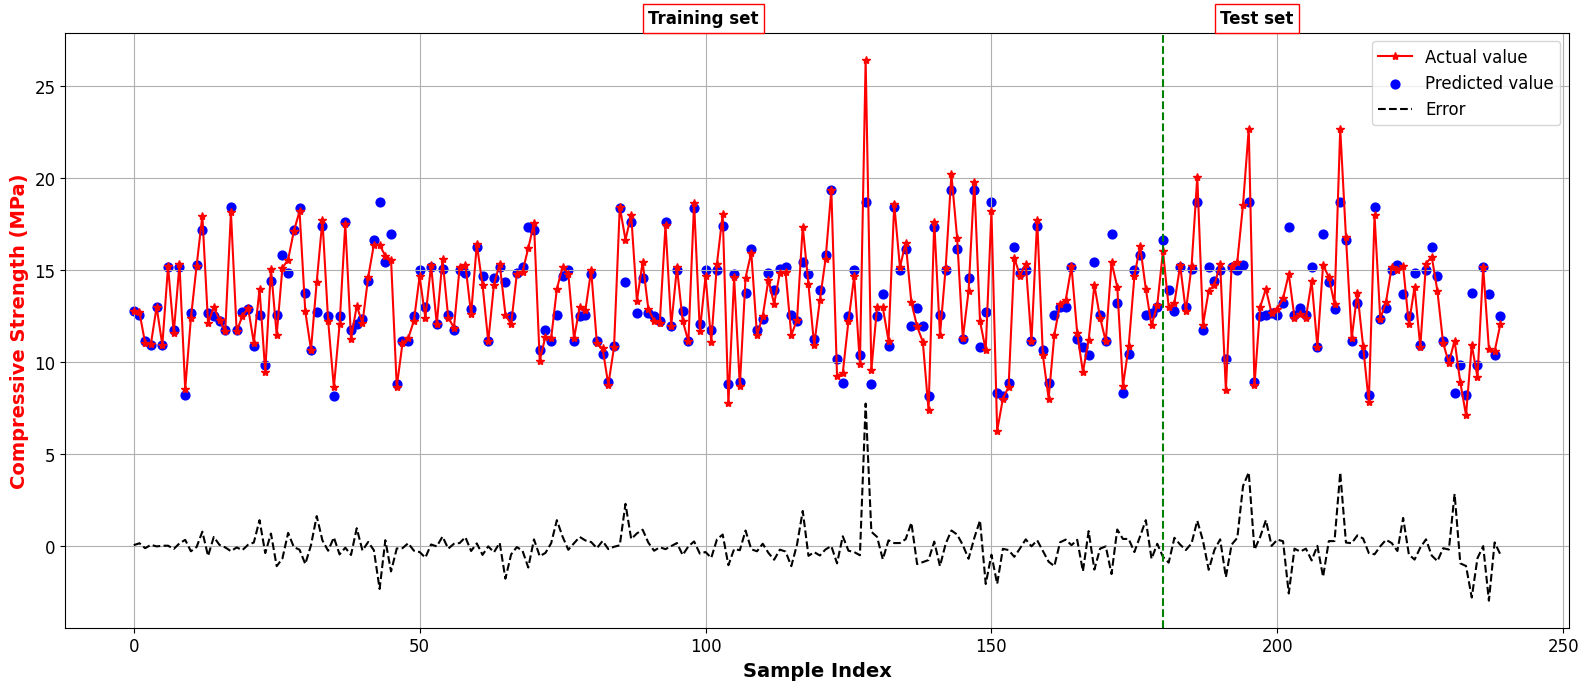

In [46]:
plot_model_performance(y_train, y_train_pred_df, y_test, y_test_pred_df, model_name="Random Forest")

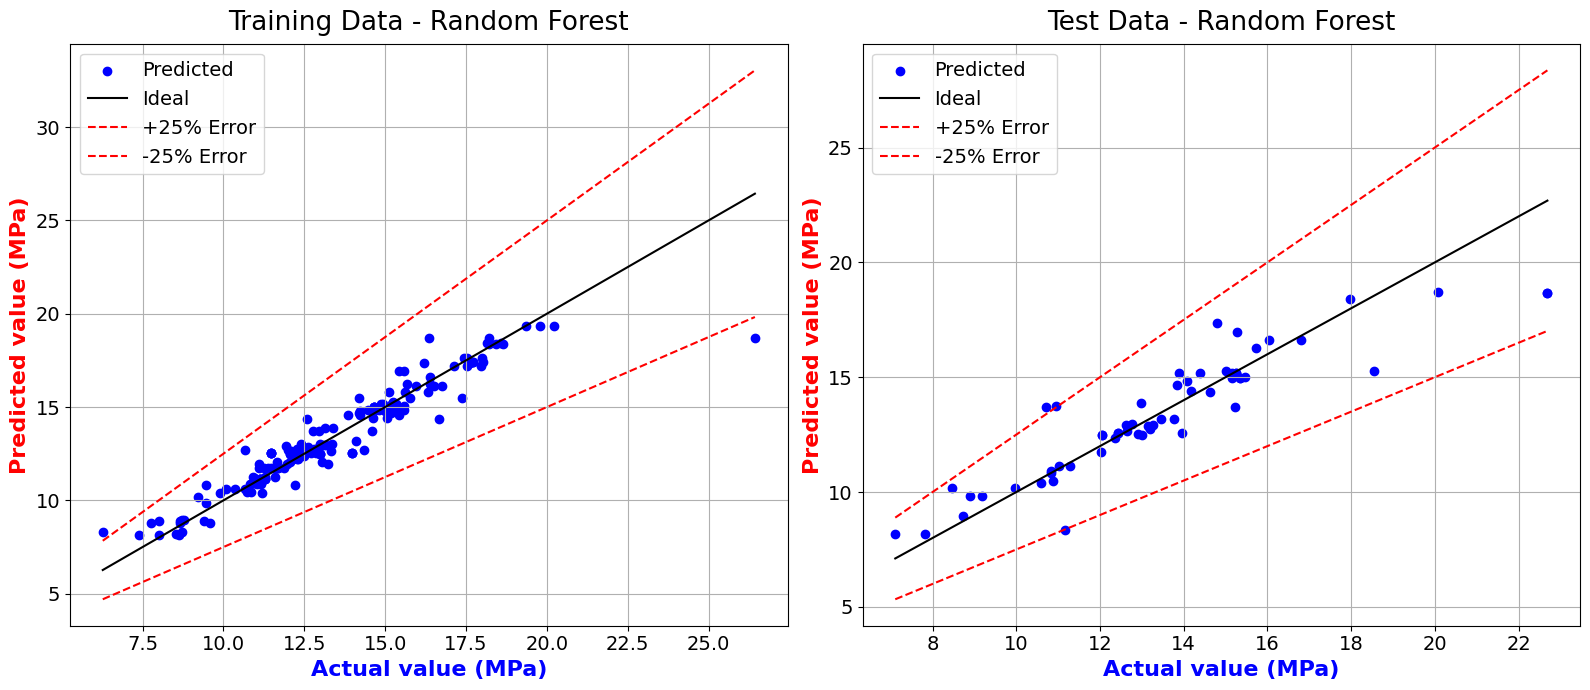

In [47]:
plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, model_name="Random Forest")

## GPR

In [48]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def objective(trial):
    constant_value = trial.suggest_float('constant_value', 0.1, 10.0, log=True)
    length_scale = trial.suggest_float('length_scale', 0.1, 10.0, log=True)
    noise_level = trial.suggest_float('noise_level', 1e-5, 1e-1, log=True)
    
    kernel = C(constant_value) * RBF(length_scale) + WhiteKernel(noise_level)
    
    model = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=5, normalize_y=True)
    
    model.fit(X_train_sub, y_train_sub)
    preds = model.predict(X_valid)
    
    r2 = r2_score(y_valid, preds)
    return r2 

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best Parameters Found by Optuna:\n", best_params)

best_kernel = C(best_params['constant_value']) * RBF(best_params['length_scale']) + WhiteKernel(best_params['noise_level'])
final_model = GaussianProcessRegressor(kernel=best_kernel, random_state=42, n_restarts_optimizer=5, normalize_y=True)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"\nTrain Set Evaluation Metrics:")
print(f"R² Score: {r2_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"MAPE: {mape_train:.4f}")

print(f"\nTest Set Evaluation Metrics:")
print(f"R² Score: {r2_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
cv_scores = cross_val_score(final_model, X_train, y_train, cv=cv, scoring='r2')
print("\nCross-Validation R² Scores:", cv_scores)
print(f"Average CV R² Score: {cv_scores.mean():.4f}")

[I 2025-09-05 10:03:27,623] A new study created in memory with name: no-name-ad57b293-e6ae-496f-8961-22b92f8ca37b
[I 2025-09-05 10:03:28,042] Trial 0 finished with value: 0.6904818759540658 and parameters: {'constant_value': 0.6164196015421906, 'length_scale': 0.8913361169739846, 'noise_level': 0.06380501468560322}. Best is trial 0 with value: 0.6904818759540658.
[I 2025-09-05 10:03:28,511] Trial 1 finished with value: 0.6904818747121662 and parameters: {'constant_value': 0.10536548350403478, 'length_scale': 1.1576155596045299, 'noise_level': 4.907174107823286e-05}. Best is trial 0 with value: 0.6904818759540658.
[I 2025-09-05 10:03:28,928] Trial 2 finished with value: 0.690481876289371 and parameters: {'constant_value': 2.8690342572466077, 'length_scale': 3.1407974891600032, 'noise_level': 0.0001976866700908783}. Best is trial 2 with value: 0.690481876289371.
[I 2025-09-05 10:03:29,353] Trial 3 finished with value: 0.690481876289371 and parameters: {'constant_value': 5.936625695762848

Best Parameters Found by Optuna:
 {'constant_value': 0.25199673188892463, 'length_scale': 4.333932688802599, 'noise_level': 0.003173635673546944}

Train Set Evaluation Metrics:
R² Score: 0.9590
MSE: 0.3432
RMSE: 0.5859
MAE: 0.3982
MAPE: 0.0317

Test Set Evaluation Metrics:
R² Score: 0.8435
MSE: 1.4747
RMSE: 1.2144
MAE: 0.7723
MAPE: 0.0580

Cross-Validation R² Scores: [0.74887828 0.85080016 0.36409556 0.88505692 0.85602261 0.92188862
 0.83847072 0.5446519  0.91977278 0.70100116]
Average CV R² Score: 0.7631


In [49]:
gpr_results = {
    'Model': 'GPR',
    'Train R²': r2_train,
    'Train MAE': mae_train,
    'Train RMSE': rmse_train,
    'Train MSE': mse_train,
    'Train MAPE': mape_train * 100,   # if you prefer percent
    'Test R²': r2_test,
    'Test MAE': mae_test,
    'Test RMSE': rmse_test,
    'Test MSE': mse_test,
    'Test MAPE': mape_test * 100,
    'CV R² Mean': cv_scores.mean()
}

gpr_results_df = pd.DataFrame([gpr_results])
results_df = pd.concat([results_df, gpr_results_df], ignore_index=True)
print(results_df)

           Model  Train R²  Train MAE  Train RMSE  Train MSE  Train MAPE  Test R²  Test MAE  Test RMSE  Test MSE  Test MAPE  CV R² Mean
0            SLR    0.6503     1.2370      1.7109     2.9272      9.9114   0.5824    1.3722     1.9839    3.9358    10.4991      0.6535
1  Random Forest    0.9069     0.5163      0.8826     0.7789      3.9314   0.8293    0.7997     1.2682    1.6084     5.9061      0.8308
2            GPR    0.9590     0.3982      0.5859     0.3432      3.1737   0.8435    0.7723     1.2144    1.4747     5.7960      0.7631


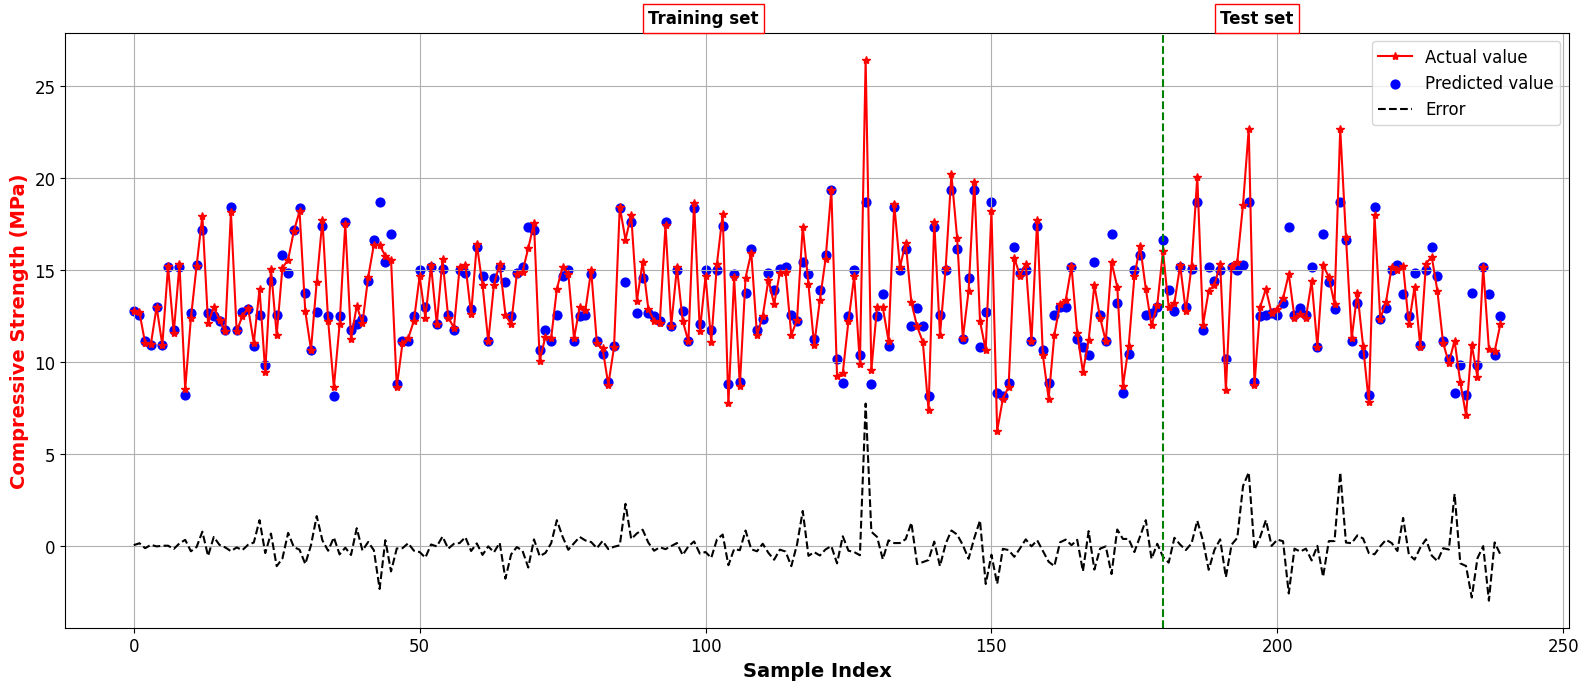

In [50]:
plot_model_performance(y_train, y_train_pred_df, y_test, y_test_pred_df, model_name="GPR")

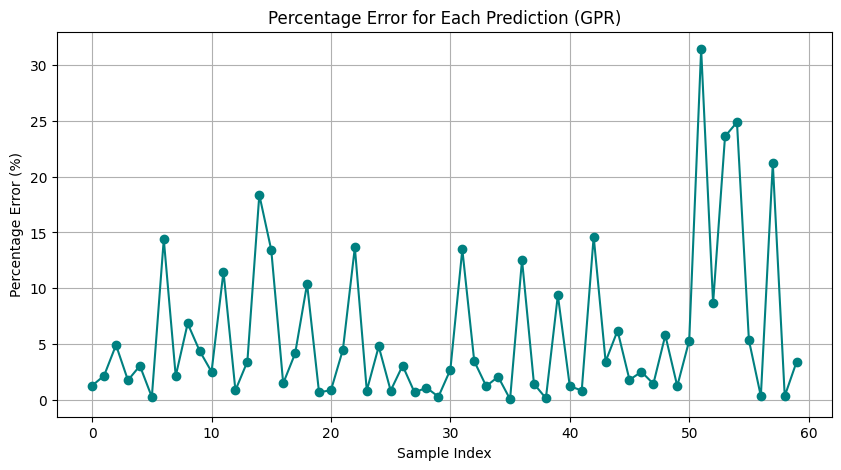

In [51]:
percentage_errors = np.abs((y_test.values.flatten() - y_test_pred.flatten()) / y_test.values.flatten()) * 100

plt.figure(figsize=(10, 5))
plt.plot(percentage_errors, marker='o', linestyle='-', color='teal')
plt.title('Percentage Error for Each Prediction (GPR)')
plt.xlabel('Sample Index')
plt.ylabel('Percentage Error (%)')
plt.grid(True)
plt.show()

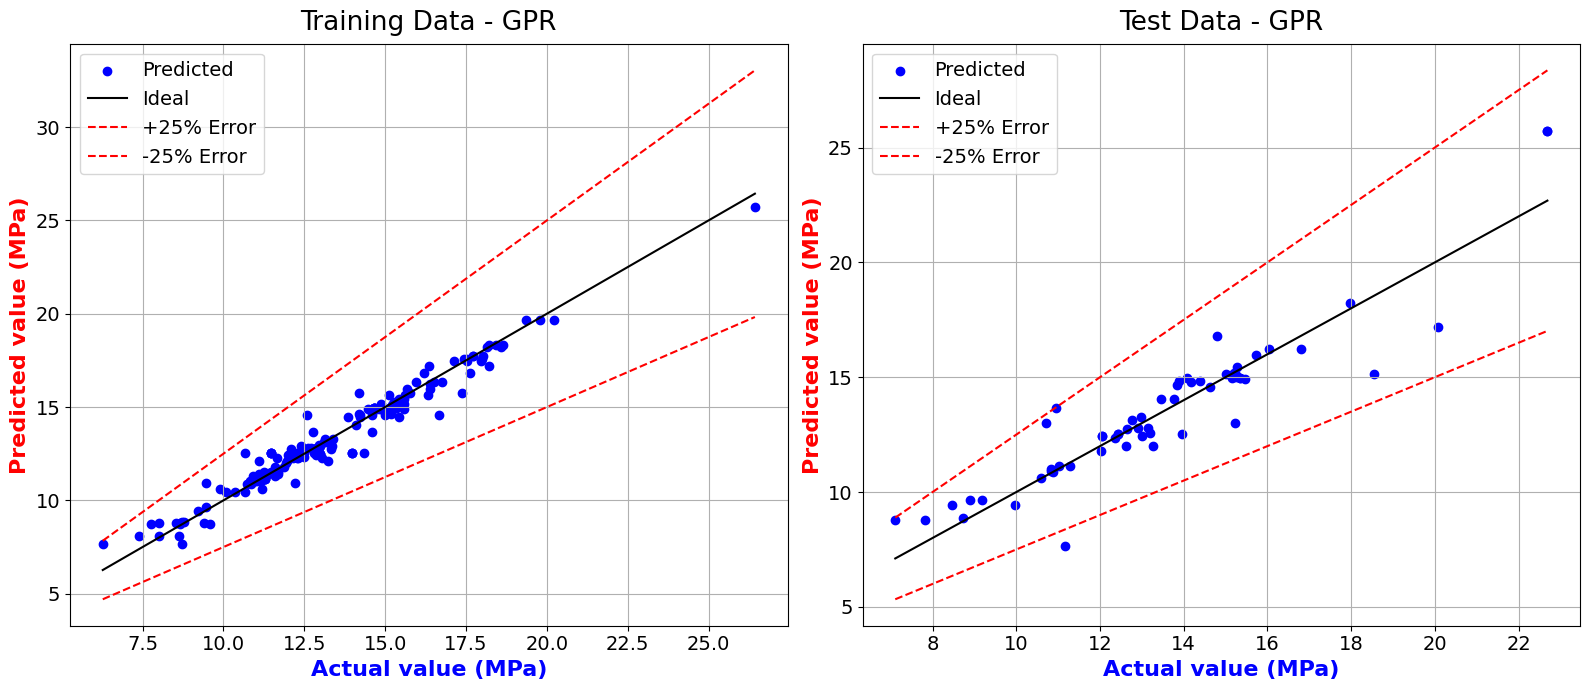

In [52]:
plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, model_name="GPR")

## XGBoost

In [53]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.5, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5),
        'random_state': 42,
        'n_jobs': -1
    }
    model = XGBRegressor(**params)
    model.fit(X_train_sub, y_train_sub, eval_set=[(X_valid, y_valid)], 
              early_stopping_rounds=20, verbose=False)
    preds = model.predict(X_valid)
    
    r2 = r2_score(y_valid, preds)
    return r2  

study = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=2500)

best_params = study.best_params
print("Best Parameters Found by Optuna:\n", best_params)

final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"\nTrain Set Evaluation Metrics:")
print(f"R² Score: {r2_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"MAPE: {mape_train:.4f}")

print(f"\nTest Set Evaluation Metrics:")
print(f"R² Score: {r2_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
cv_scores = cross_val_score(final_model, X_train, y_train, cv=cv, scoring='r2')
print("\nCross-Validation R² Scores:", cv_scores)
print(f"Average CV R² Score: {cv_scores.mean():.4f}")

[I 2025-09-05 10:04:18,048] A new study created in memory with name: no-name-8eb9643e-6b08-4a8a-a629-4ee15789f973


Best Parameters Found by Optuna:
 {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.1743086649534823, 'subsample': 0.9456653080949784, 'colsample_bytree': 0.7226071105375069, 'gamma': 0.5717026971628184, 'reg_alpha': 0.5765455752444102, 'reg_lambda': 3.5500598154826637}

Train Set Evaluation Metrics:
R² Score: 0.9261
MSE: 0.6182
RMSE: 0.7862
MAE: 0.5153
MAPE: 0.0409

Test Set Evaluation Metrics:
R² Score: 0.8903
MSE: 1.0336
RMSE: 1.0167
MAE: 0.6872
MAPE: 0.0526

Cross-Validation R² Scores: [0.93714747 0.90550764 0.62577968 0.9229091  0.86462623 0.93575773
 0.92106753 0.79465934 0.92322408 0.63102713]
Average CV R² Score: 0.8462


In [54]:
xgb_results = {
    'Model': 'XGBoost',
    'Train R²': r2_train,
    'Train MAE': mae_train,
    'Train RMSE': rmse_train,
    'Train MSE': mse_train,
    'Train MAPE': mape_train * 100,   # if you prefer percent
    'Test R²': r2_test,
    'Test MAE': mae_test,
    'Test RMSE': rmse_test,
    'Test MSE': mse_test,
    'Test MAPE': mape_test * 100,
    'CV R² Mean': cv_scores.mean()
}


xgb_results_df = pd.DataFrame([xgb_results])
results_df = pd.concat([results_df, xgb_results_df], ignore_index=True)
print(results_df)

           Model  Train R²  Train MAE  Train RMSE  Train MSE  Train MAPE  Test R²  Test MAE  Test RMSE  Test MSE  Test MAPE  CV R² Mean
0            SLR    0.6503     1.2370      1.7109     2.9272      9.9114   0.5824    1.3722     1.9839    3.9358    10.4991      0.6535
1  Random Forest    0.9069     0.5163      0.8826     0.7789      3.9314   0.8293    0.7997     1.2682    1.6084     5.9061      0.8308
2            GPR    0.9590     0.3982      0.5859     0.3432      3.1737   0.8435    0.7723     1.2144    1.4747     5.7960      0.7631
3        XGBoost    0.9261     0.5153      0.7862     0.6182      4.0860   0.8903    0.6872     1.0167    1.0336     5.2580      0.8462


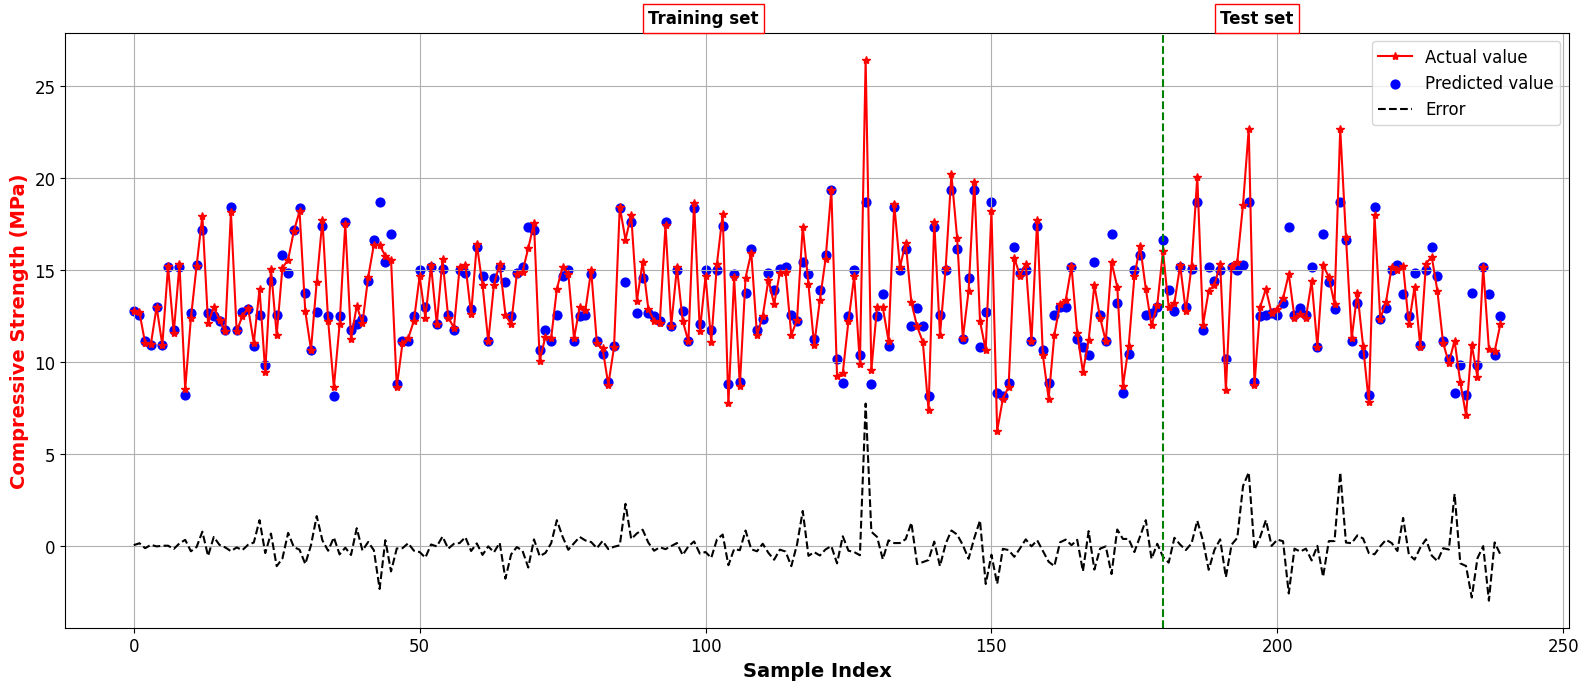

In [55]:
plot_model_performance(y_train, y_train_pred_df, y_test, y_test_pred_df, model_name="XGBoost")

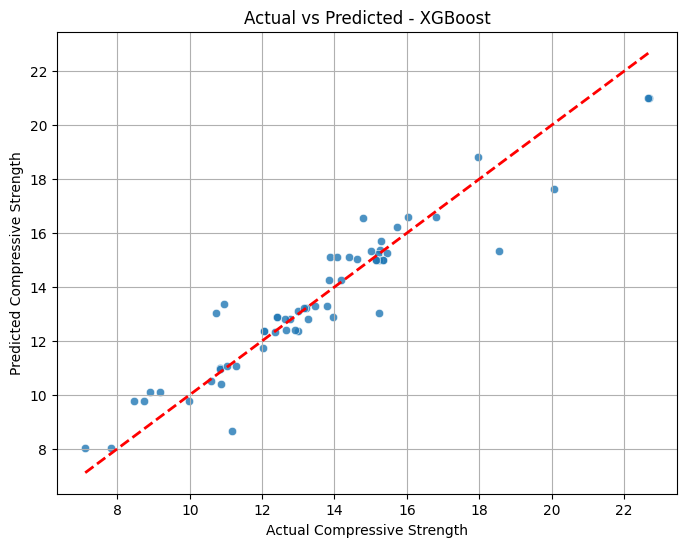

In [56]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test.values.flatten(), y=y_test_pred, alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title('Actual vs Predicted - XGBoost')
plt.grid(True)
plt.show()

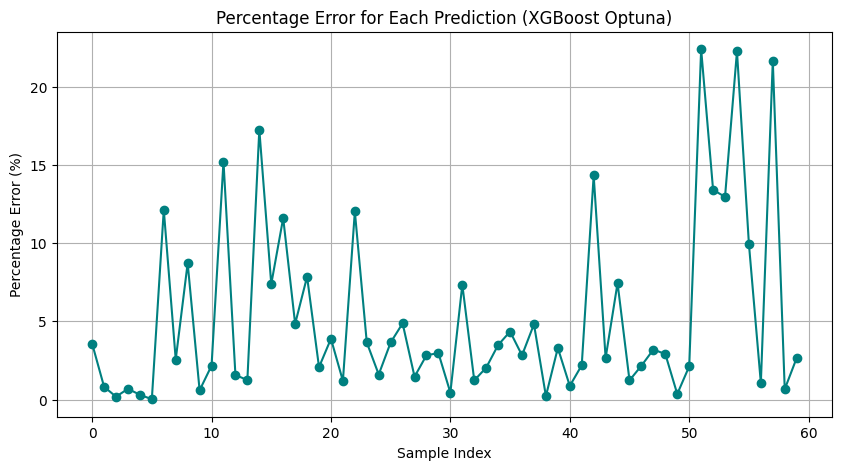

In [57]:
percentage_errors = np.abs((y_test.values.flatten() - y_test_pred.flatten()) / y_test.values.flatten()) * 100

plt.figure(figsize=(10, 5))
plt.plot(percentage_errors, marker='o', linestyle='-', color='teal')
plt.title('Percentage Error for Each Prediction (XGBoost Optuna)')
plt.xlabel('Sample Index')
plt.ylabel('Percentage Error (%)')
plt.grid(True)
plt.show()

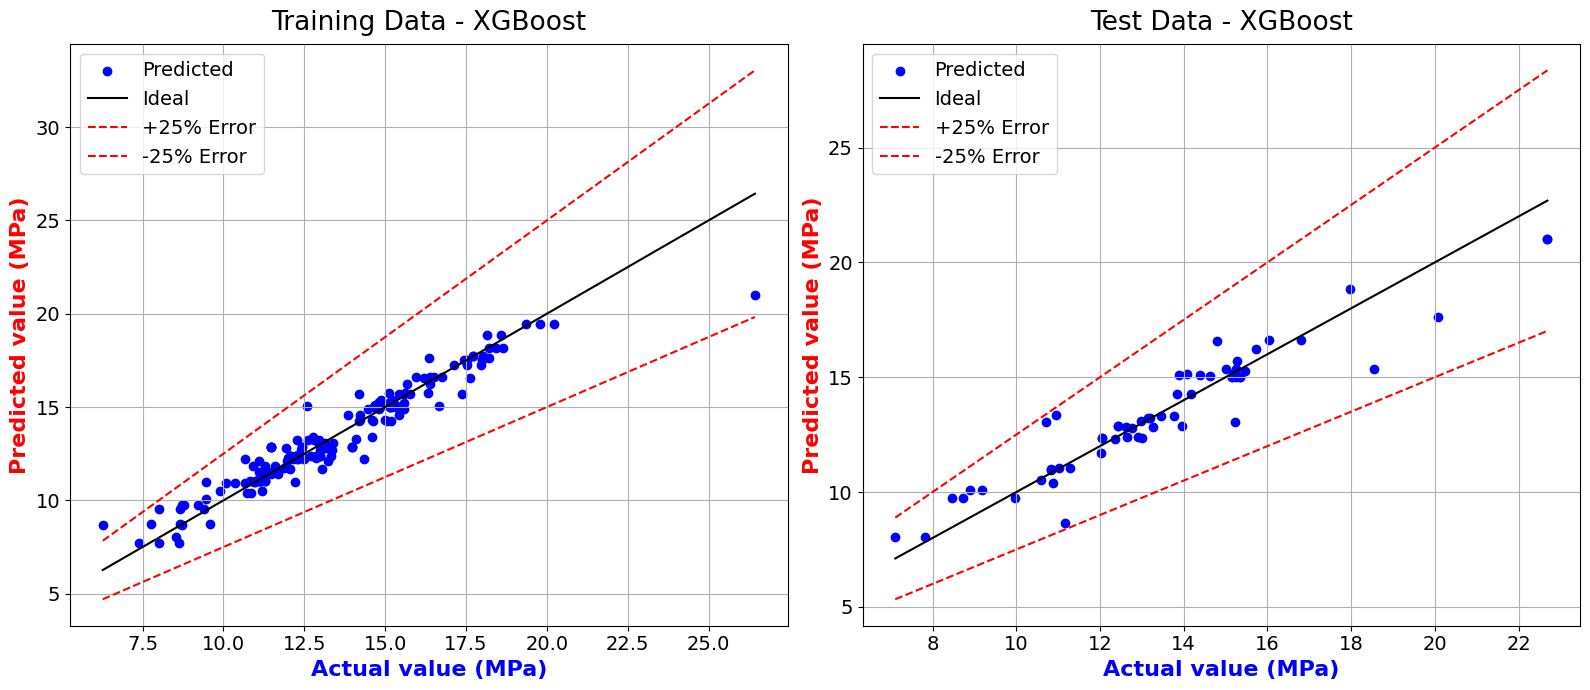

In [58]:
plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, model_name="XGBoost")

## LightGBM

Fitting 5 folds for each of 5040 candidates, totalling 25200 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 180, number of used features: 6
[LightGBM] [Info] Start training from score 13.400944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

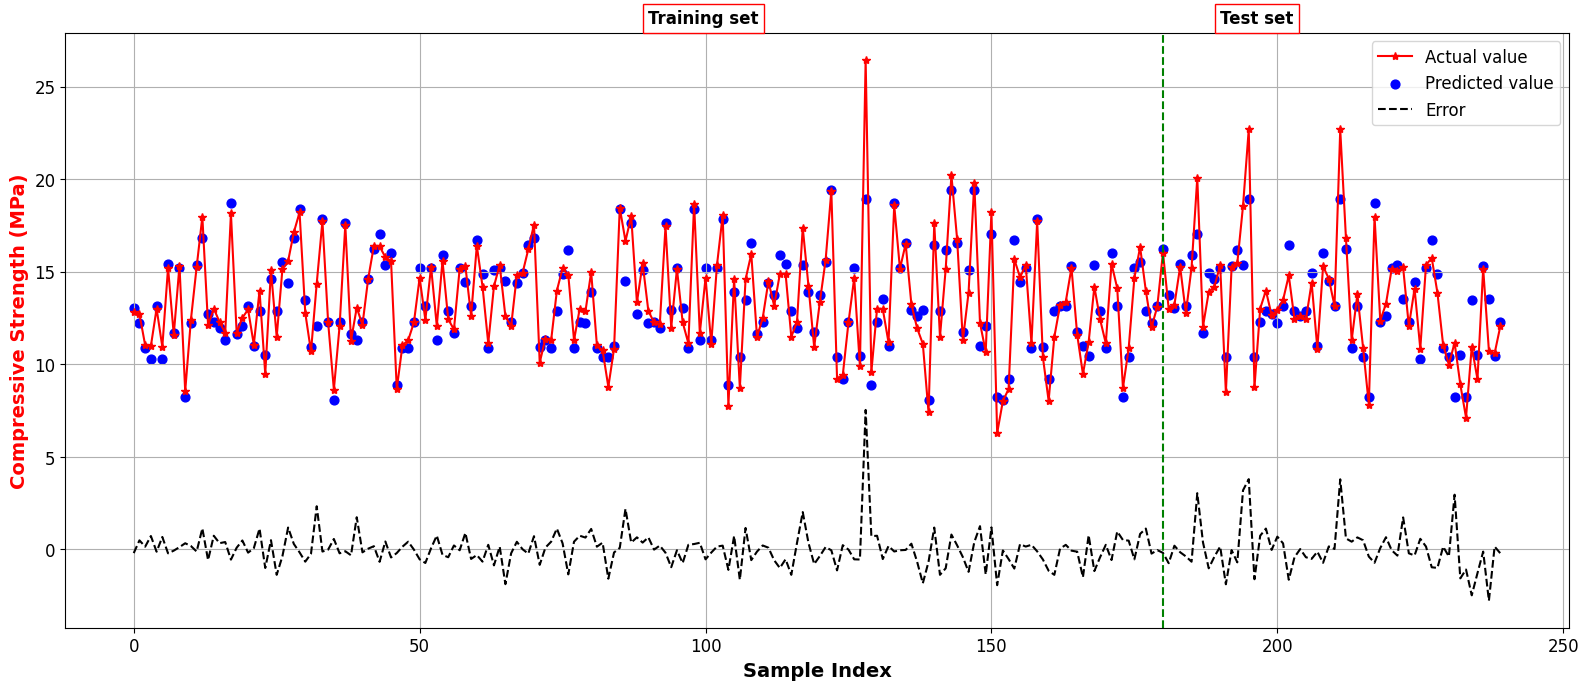

In [59]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

param_grid_lgb = {
    'n_estimators': [20, 30, 50, 75, 100],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2],
    'num_leaves': [20, 25, 30, 35, 40, 45, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


lgb_model = lgb.LGBMRegressor(random_state=42)

grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid_search_lgb.fit(X_train, y_train)

print(grid_search_lgb.best_params_)
best_lgb_model = grid_search_lgb.best_estimator_

y_train_pred_lgb = best_lgb_model.predict(X_train)
y_test_pred_lgb = best_lgb_model.predict(X_test)

if isinstance(y_train, pd.DataFrame):
    y_train_pred_lgb = pd.DataFrame(y_train_pred_lgb, columns=y_train.columns)
    y_test_pred_lgb = pd.DataFrame(y_test_pred_lgb, columns=y_test.columns)
else:
    y_train_pred_lgb = pd.Series(y_train_pred_lgb)
    y_test_pred_lgb = pd.Series(y_test_pred_lgb)

mse_train_lgb = mean_squared_error(y_train, y_train_pred_lgb)
rmse_train_lgb = np.sqrt(mse_train_lgb)
mae_train_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
r2_train_lgb = r2_score(y_train, y_train_pred_lgb)
mape_train_lgb = mean_absolute_percentage_error(y_train, y_train_pred_lgb)

mse_test_lgb = mean_squared_error(y_test, y_test_pred_lgb)
rmse_test_lgb = np.sqrt(mse_test_lgb)
mae_test_lgb = mean_absolute_error(y_test, y_test_pred_lgb)
r2_test_lgb = r2_score(y_test, y_test_pred_lgb)
mape_test_lgb = mean_absolute_percentage_error(y_test, y_test_pred_lgb)

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
cv_scores_lgb = cross_val_score(best_lgb_model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
cv_mean_lgb = cv_scores_lgb.mean()

lgb_results = {
    'Model': 'LightGBM',
    'Train R²': r2_train_lgb,
    'Train MAE': mae_train_lgb,
    'Train RMSE': rmse_train_lgb,
    'Train MSE': mse_train_lgb,
    'Train MAPE': mape_train_lgb * 100,
    'Test R²': r2_test_lgb,
    'Test MAE': mae_test_lgb,
    'Test RMSE': rmse_test_lgb,
    'Test MSE': mse_test_lgb,
    'Test MAPE': mape_test_lgb * 100,
    'CV R² Mean': cv_mean_lgb
}

lgb_results_df = pd.DataFrame([lgb_results])
results_df = pd.concat([results_df, lgb_results_df], ignore_index=True)

plot_model_performance(y_train, y_train_pred_lgb, y_test, y_test_pred_lgb, model_name="LightGBM")

In [60]:
results_df

,Model,Train R²,Train MAE,Train RMSE,Train MSE,Train MAPE,Test R²,Test MAE,Test RMSE,Test MSE,Test MAPE,CV R² Mean
0,SLR,0.6503,1.2370,1.7109,2.9272,9.9114,0.5824,1.3722,1.9839,3.9358,10.4991,0.6535
1,Random Forest,0.9069,0.5163,0.8826,0.7789,3.9314,0.8293,0.7997,1.2682,1.6084,5.9061,0.8308
2,GPR,0.9590,0.3982,0.5859,0.3432,3.1737,0.8435,0.7723,1.2144,1.4747,5.7960,0.7631
3,XGBoost,0.9261,0.5153,0.7862,0.6182,4.0860,0.8903,0.6872,1.0167,1.0336,5.2580,0.8462
4,LightGBM,0.8971,0.5975,0.9282,0.8616,4.6701,0.8237,0.8650,1.2889,1.6613,6.5640,0.8049


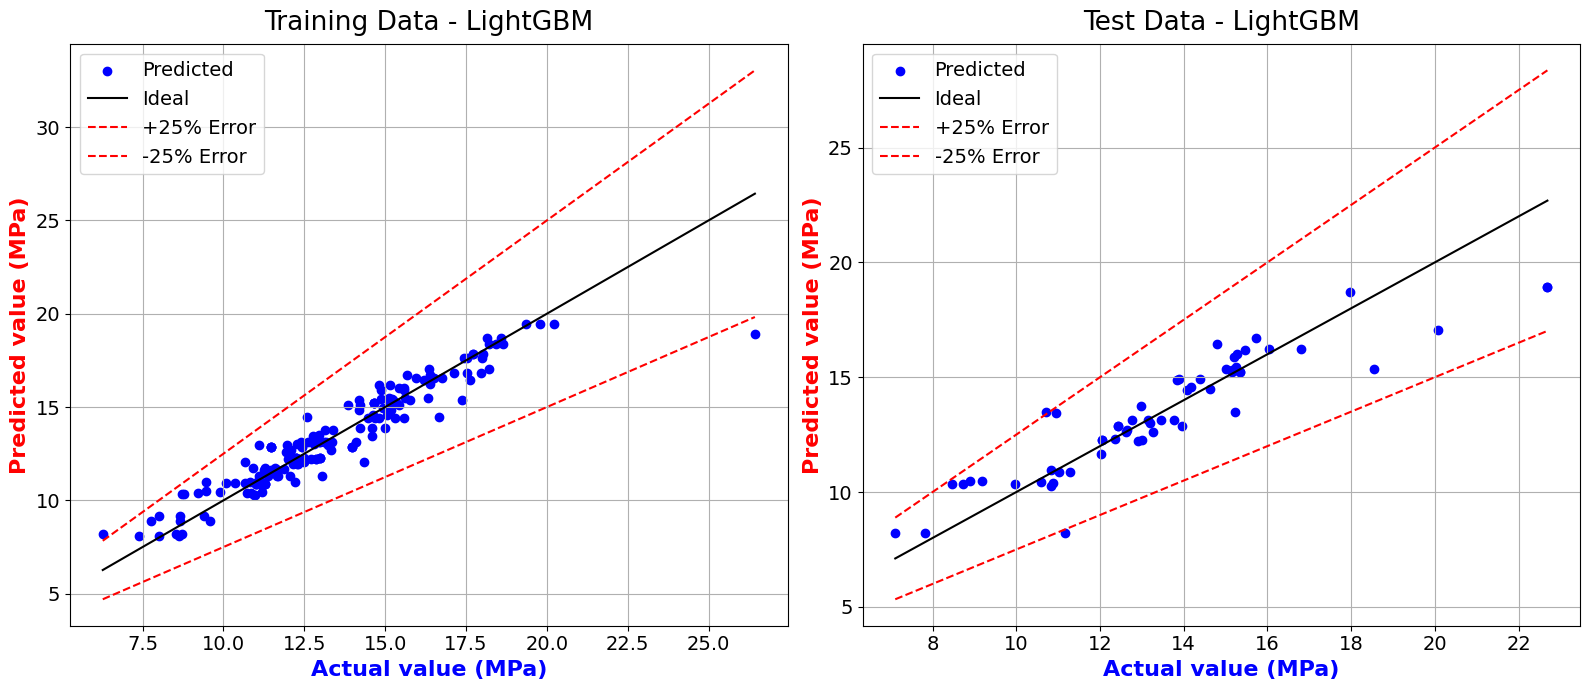

In [61]:
plot_actual_vs_predicted(y_train, y_train_pred_lgb, y_test, y_test_pred_lgb, model_name="LightGBM")

## SVR

In [62]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()

param_grid = {
    'svr__C': [1, 10, 50, 100],
    'svr__epsilon': [0.01, 0.05, 0.1],
    'svr__gamma': ['scale', 'auto']
}

pipeline = Pipeline([
    ('svr', SVR(kernel='rbf'))
])

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

best_svr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_train_pred_scaled = best_svr.predict(X_train_scaled)
y_test_pred_scaled = best_svr.predict(X_test_scaled)

y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

def evaluate(y_true, y_pred, label="Set"):
    print(f"\n{label} Set Evaluation:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}")

evaluate(y_train, y_train_pred, "Train")
evaluate(y_test, y_test_pred, "Test")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.05, 'svr__gamma': 'auto'}

Train Set Evaluation:
R² Score: 0.8862
RMSE: 0.9760
MAE: 0.5893
MAPE: 0.0470

Test Set Evaluation:
R² Score: 0.8516
RMSE: 1.1828
MAE: 0.8429
MAPE: 0.0640


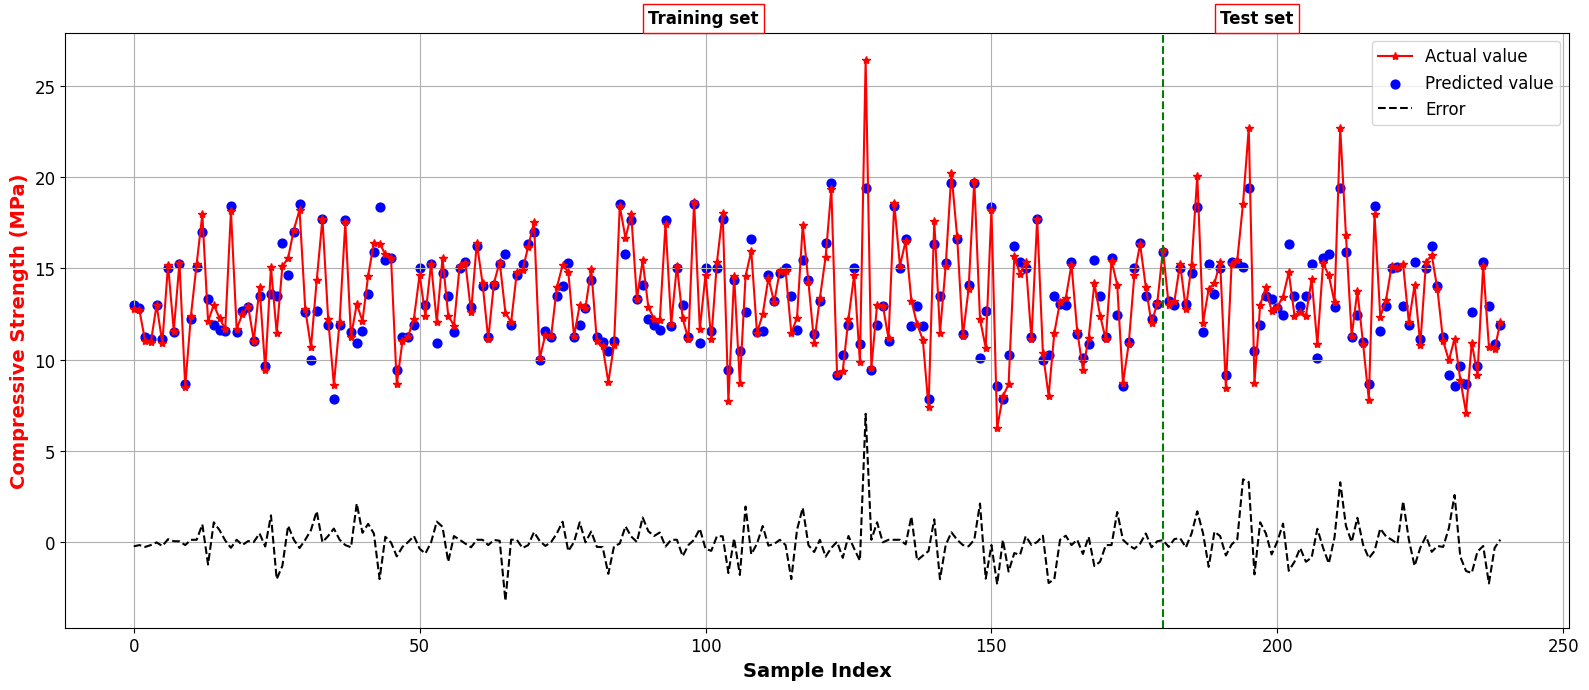

In [63]:
mse_train_svr = mean_squared_error(y_train, y_train_pred)
rmse_train_svr = np.sqrt(mse_train_svr)
mae_train_svr = mean_absolute_error(y_train, y_train_pred)
r2_train_svr = r2_score(y_train, y_train_pred)
mape_train_svr = mean_absolute_percentage_error(y_train, y_train_pred)

mse_test_svr = mean_squared_error(y_test, y_test_pred)
rmse_test_svr = np.sqrt(mse_test_svr)
mae_test_svr = mean_absolute_error(y_test, y_test_pred)
r2_test_svr = r2_score(y_test, y_test_pred)
mape_test_svr = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores_svr = cross_val_score(best_svr, X_train_scaled, y_train_scaled, scoring='r2', cv=cv, n_jobs=-1)
cv_mean_svr = cv_scores_svr.mean()

svr_results = {
    'Model': 'SVR',
    'Train R²': r2_train_svr,
    'Train MAE': mae_train_svr,
    'Train RMSE': rmse_train_svr,
    'Train MSE': mse_train_svr,
    'Train MAPE': mape_train_svr * 100,
    'Test R²': r2_test_svr,
    'Test MAE': mae_test_svr,
    'Test RMSE': rmse_test_svr,
    'Test MSE': mse_test_svr,
    'Test MAPE': mape_test_svr * 100,
    'CV R² Mean': cv_mean_svr
}

svr_results_df = pd.DataFrame([svr_results])
results_df = pd.concat([results_df, svr_results_df], ignore_index=True)  # or append to the end, adjust as needed

y_train_pred = pd.Series(y_train_pred.flatten())
y_test_pred = pd.Series(y_test_pred.flatten())

plot_model_performance(y_train, y_train_pred, y_test, y_test_pred, model_name="SVR")

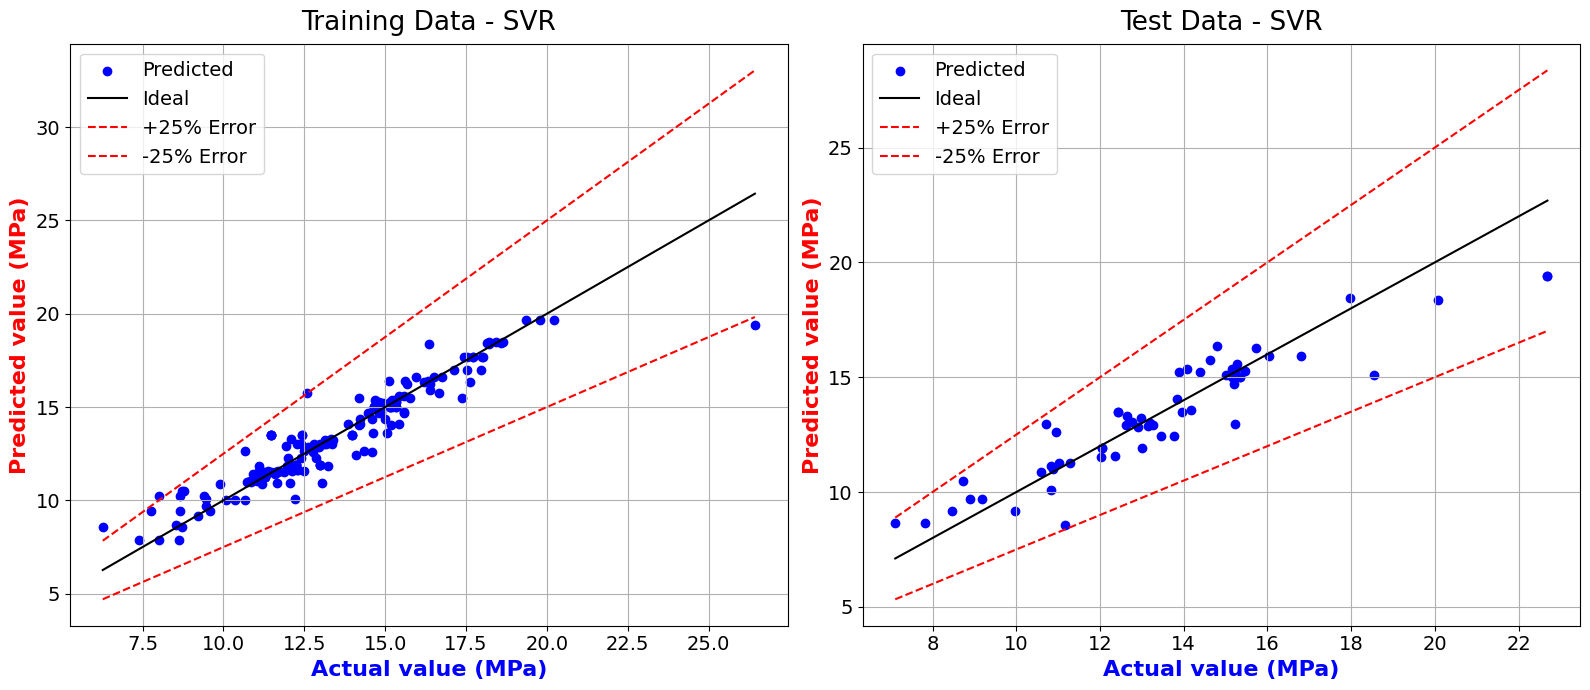

In [64]:
plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, model_name="SVR")

In [65]:
results_df

,Model,Train R²,Train MAE,Train RMSE,Train MSE,Train MAPE,Test R²,Test MAE,Test RMSE,Test MSE,Test MAPE,CV R² Mean
0,SLR,0.6503,1.2370,1.7109,2.9272,9.9114,0.5824,1.3722,1.9839,3.9358,10.4991,0.6535
1,Random Forest,0.9069,0.5163,0.8826,0.7789,3.9314,0.8293,0.7997,1.2682,1.6084,5.9061,0.8308
2,GPR,0.9590,0.3982,0.5859,0.3432,3.1737,0.8435,0.7723,1.2144,1.4747,5.7960,0.7631
3,XGBoost,0.9261,0.5153,0.7862,0.6182,4.0860,0.8903,0.6872,1.0167,1.0336,5.2580,0.8462
4,LightGBM,0.8971,0.5975,0.9282,0.8616,4.6701,0.8237,0.8650,1.2889,1.6613,6.5640,0.8049
5,SVR,0.8862,0.5893,0.9760,0.9525,4.7017,0.8516,0.8429,1.1828,1.3990,6.3990,0.8179


# SHAP Analysis

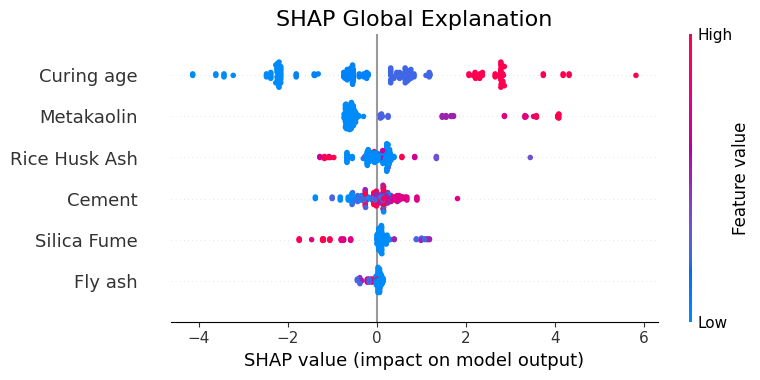

In [47]:
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_train)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("SHAP Global Explanation", fontsize=16)
plt.tight_layout()
plt.savefig("shap_beeswarm_plot_resized.png", dpi=300, bbox_inches='tight')
plt.show()

In [50]:
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)
preds = final_model.predict(X_test)
base_value = shap_values.base_values[0]

diff = preds - base_value

idx_near_base = np.argmin(np.abs(diff))
idx_high = np.argmax(diff)
idx_low = np.argmin(diff)

mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.figsize'] = (12, 3.5)
mpl.rcParams['axes.labelsize'] = 12

def save_force_plot(idx, name):
    fig = shap.plots.force(shap_values[idx], matplotlib=True, show=False)
    ax = fig.axes[0]  
    for text in ax.texts:
        if text.get_text().strip().lower() == "base value":
            text.set_y(text.get_position()[1] + 0.05)
        if text.get_text().strip().startswith("f(x)"):
            text.set_y(text.get_position()[1] - 0.05)

    fig.savefig(f"{name}_shap_fixed.png", dpi=300, bbox_inches='tight')
    fig.savefig(f"{name}_shap_fixed.pdf", bbox_inches='tight')
    plt.close(fig)
    print(f"Fixed and saved: {name}_shap_fixed.png & .pdf")

save_force_plot(idx_near_base, "near_base")
save_force_plot(idx_high, "higher_than_base")
save_force_plot(idx_low, "lower_than_base")

Fixed and saved: near_base_shap_fixed.png & .pdf
Fixed and saved: higher_than_base_shap_fixed.png & .pdf
Fixed and saved: lower_than_base_shap_fixed.png & .pdf


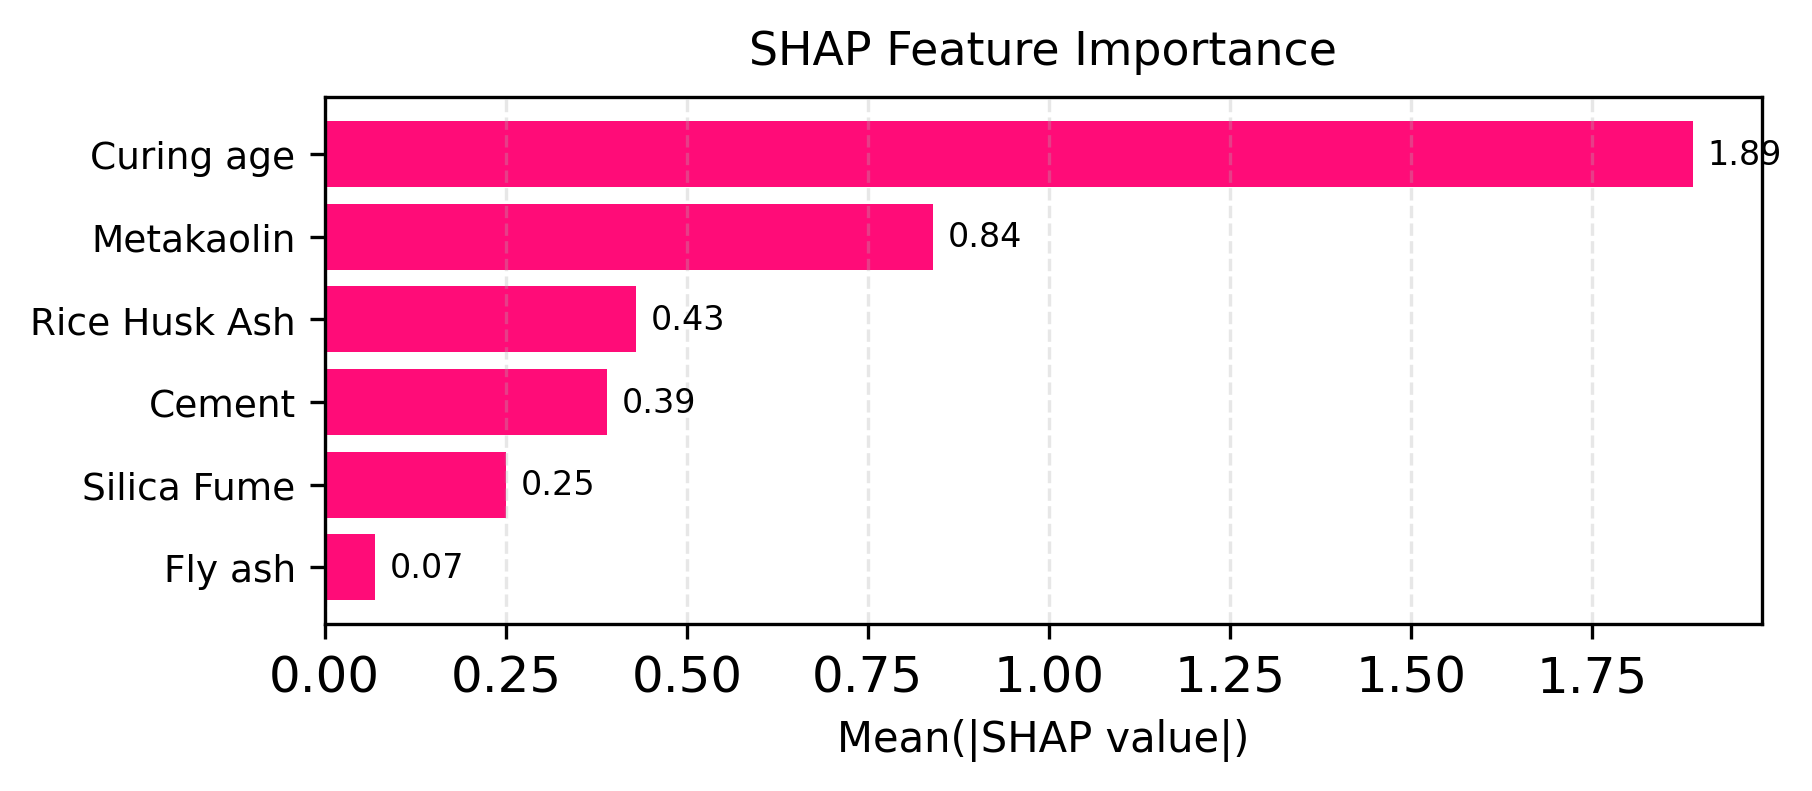

In [51]:
feature_names = ["Curing age", "Metakaolin", "Rice Husk Ash", "Cement", "Silica Fume", "Fly ash"]
mean_shap_values = np.array([1.89, 0.84, 0.43, 0.39, 0.25, 0.07])

sorted_idx = np.argsort(mean_shap_values)[::-1]
mean_shap_values = mean_shap_values[sorted_idx]
feature_names = np.array(feature_names)[sorted_idx]

plt.figure(figsize=(6.2, 2.8), dpi=300)  # shorter height, moderate width
bars = plt.barh(range(len(mean_shap_values)), mean_shap_values, color="#ff0c78")

plt.yticks(range(len(mean_shap_values)), feature_names, fontsize=9)
plt.xlabel("Mean(|SHAP value|)", fontsize=10)
plt.title("SHAP Feature Importance", fontsize=11, pad=8)

for i, v in enumerate(mean_shap_values):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center', ha='left', fontsize=8)

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig("shap_summary.png", dpi=300, bbox_inches='tight')
plt.savefig("shap_summary.pdf", bbox_inches='tight')
plt.show()

In [52]:
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values.values,
    X_test
)

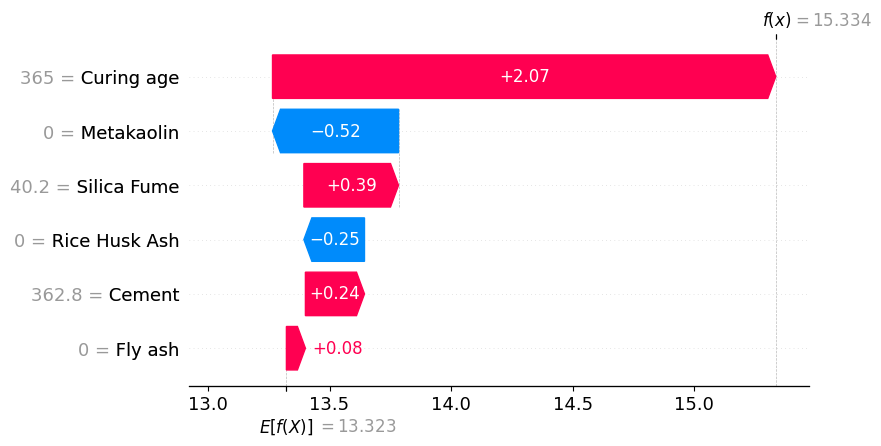

In [53]:
sample_index = 5
shap.plots.waterfall(shap_values[sample_index], max_display=10)

# PDP Analysis

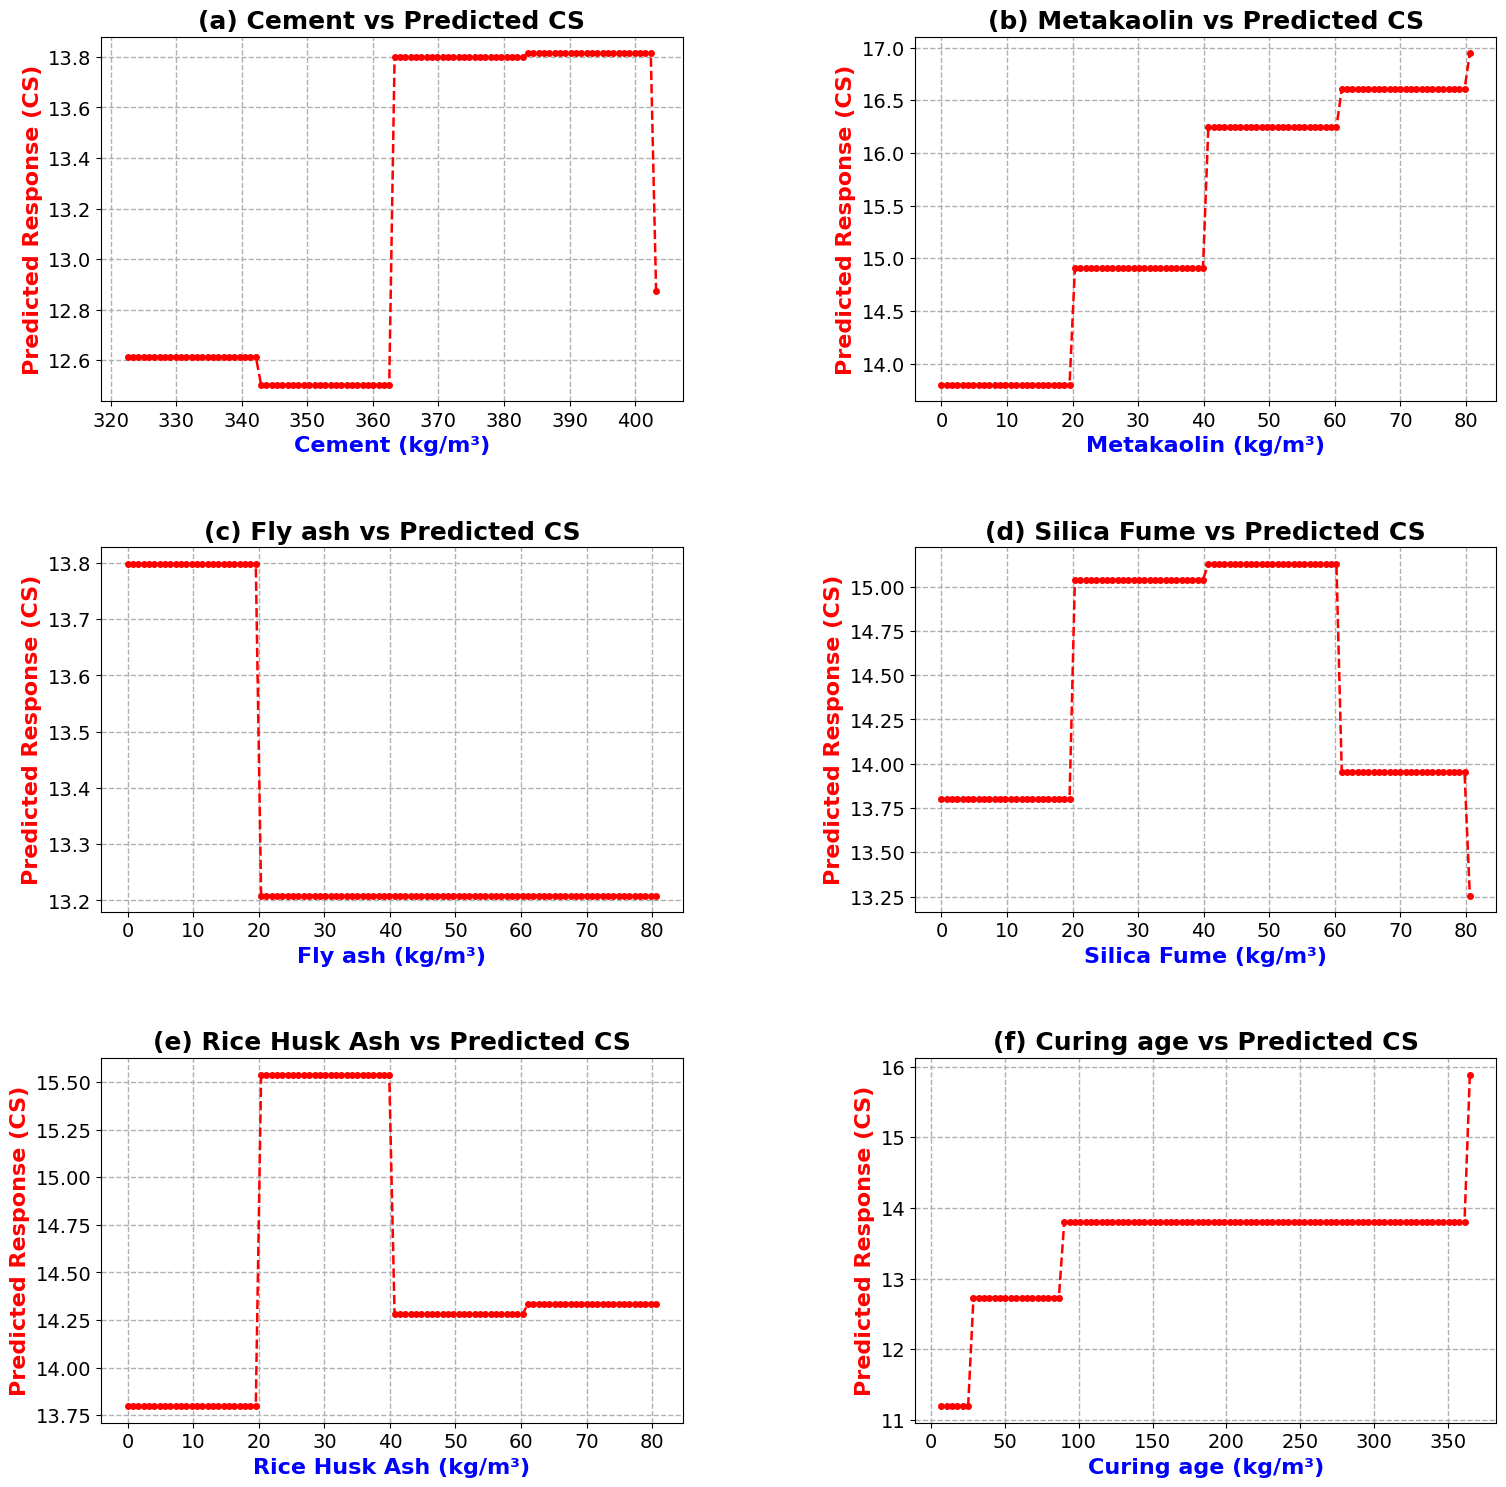

In [76]:
from math import ceil
n_features = len(X.columns)
n_rows = ceil(n_features / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(18, n_rows * 6))  # 2 per row
axs = axs.ravel()

for i, col in enumerate(X.columns):
    x_vals = np.linspace(data[col].min(), data[col].max(), 100)
    preds = []
    
    for val in x_vals:
        temp = X.mean().to_frame().T
        temp[col] = val
        pred = final_model.predict(temp)[0]
        preds.append(pred)
    
    axs[i].plot(x_vals, preds, 'r--', marker='o', markersize=4, linewidth=1.8)
    axs[i].set_title(f'({chr(97 + i)}) {col} vs Predicted CS', fontsize=18, fontweight='bold')
    axs[i].set_xlabel(f'{col} (kg/m³)', fontsize=16, color='blue', fontweight='bold')
    axs[i].set_ylabel('Predicted Response (CS)', fontsize=16, color='red', fontweight='bold')
    axs[i].tick_params(axis='both', labelsize=14)
    axs[i].grid(True, linestyle="--", linewidth=1)

for j in range(len(X.columns), len(axs)):
    fig.delaxes(axs[j])

plt.subplots_adjust(hspace=0.4, wspace=0.4)  # increase gaps
plt.show()
